# Classification of low/high confidence in Iowa Gambling Task

In [41]:
import os
import pip
import sys
print(sys.executable)
#Check that we have something installed.
import nilearn
import nibabel as nib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import seaborn as sns
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
import pickle
from nilearn.masking import apply_mask, unmask
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiMasker

/work/student_folders/sabrina_folder/virt_env/bin/python


In [42]:
# Define the base data directory
data_dir = os.path.join(os.path.expanduser('/work/fMRI_data/BIDS_2024E'), 'derivatives')
print("Data directory:", data_dir)

# Dictionaries to store relevant files for each subject
anat_data = {}
func_data = {}

# Loop through all folders in the derivatives directory that start with "sub-XXXX" and are directories
for subject_folder in sorted(os.listdir(data_dir)):
    subject_path = os.path.join(data_dir, subject_folder)
    if subject_folder.startswith("sub-") and os.path.isdir(subject_path):  # Ensure it's a directory
        # Define the session folder path
        ses_dir = os.path.join(subject_path, 'ses-001')
        
        # Define paths for anat and func folders within each session
        anat_dir = os.path.join(ses_dir, 'anat')
        func_dir = os.path.join(ses_dir, 'func')
        
        # Store anat data paths if folder exists
        if os.path.exists(anat_dir):
            anat_data[subject_folder] = sorted(os.listdir(anat_dir))
        
        # Load functional data
        if os.path.exists(func_dir):
            # Initialize subject-specific dictionaries for func data
            func_data[subject_folder] = {}
            
            # Define paths for BOLD, brain mask, and confounds files
            bold_file = [f for f in os.listdir(func_dir) if 'desc-preproc_bold.nii.gz' in f]
            confounds_file = [f for f in os.listdir(func_dir) if 'desc-confounds_timeseries.tsv' in f]
            brain_mask_file = [f for f in os.listdir(func_dir) if f.endswith('desc-brain_mask.nii.gz')]  # Search for exact mask filename ending

            # Load confounds data if the file is present
            if confounds_file:
                confounds_path = os.path.join(func_dir, confounds_file[0])
                confounds_df = pd.read_csv(confounds_path, sep='\t')
                func_data[subject_folder]['confounds'] = confounds_df

            # Store BOLD and brain mask paths if files are present
            if bold_file:
                bold_path = os.path.join(func_dir, bold_file[0])
                func_data[subject_folder]['bold'] = bold_path
            
            if brain_mask_file:  # Check and assign brain mask if found
                brain_mask_path = os.path.join(func_dir, brain_mask_file[0])
                func_data[subject_folder]['brain_mask'] = brain_mask_path

# Print out loaded data structure for verification
print("Anatomical Data:", anat_data)
print("Functional Data:", func_data)

Data directory: /work/fMRI_data/BIDS_2024E/derivatives
Anatomical Data: {'sub-0136': ['sub-0136_ses-001_acq-T1sequence_run-1_desc-brain_mask.json', 'sub-0136_ses-001_acq-T1sequence_run-1_desc-brain_mask.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_desc-preproc_T1w.json', 'sub-0136_ses-001_acq-T1sequence_run-1_desc-preproc_T1w.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_dseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5', 'sub-0136_ses-001_acq-T1sequence_run-1_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5', 'sub-0136_ses-001_acq-T1sequence_run-1_label-CSF_probseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_label-GM_probseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_label-WM_probseg.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.json', 'sub-0136_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz', 'sub-0136_ses-001_acq-T1sequence_run-1_space-MNI152

In [29]:
import nibabel as nib

# Load the fMRI image
fmri_img_path = func_data["sub-0140"]["bold"] 
fmri_img = nib.load(fmri_img_path)

# Get the spatial dimensions (x, y, z) and the number of time points (t)
x_voxels, y_voxels, z_voxels, time_points = fmri_img.shape

# Get voxel dimensions (in mm)
voxel_dims = fmri_img.header.get_zooms()  # Returns a tuple of (x, y, z, t) in mm and seconds

# Print the information
print(f"The fMRI images contain {x_voxels} voxels in the x-axis, {y_voxels} voxels in the y-axis, "
      f"{z_voxels} voxels in the z-axis, and {time_points} time points, with the spatiotemporal dimensions of "
      f"({voxel_dims[0]}mm, {voxel_dims[1]}mm, {voxel_dims[2]}mm, {voxel_dims[3]}s) in millimetres (mm) and seconds (s).")


The fMRI images contain 78 voxels in the x-axis, 92 voxels in the y-axis, 78 voxels in the z-axis, and 600 time points, with the spatiotemporal dimensions of (2.5260000228881836mm, 2.5260000228881836mm, 2.5mm, 1.0s) in millimetres (mm) and seconds (s).


In [43]:
# Define the base directory for events data and load behavioral data
events_data_dir = os.path.expanduser('/work/fMRI_data/BIDS_2024E')
behavioral_data = pd.read_csv("/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/out/merged_df.csv")

# Initialize a dictionary to store each subject's merged DataFrame
subject_events_data = {}

# Process each subject folder to collect and merge events with behavioral data
for subject_folder in sorted(os.listdir(events_data_dir)):
    if not subject_folder.startswith("sub-"):
        continue

    # Identify subject numeric ID
    subj_numeric_id = int(subject_folder.split('-')[1])
    
    # Define path to session's functional data folder
    ses_dir = os.path.join(events_data_dir, subject_folder, 'ses-001', 'func')
    if not os.path.isdir(ses_dir):
        continue

    # Initialize a list to gather DataFrames for each session
    subject_data_list = []
    
    # Process each event file in the session directory
    for event_file in filter(lambda f: f.endswith("events.tsv"), os.listdir(ses_dir)):
        event_path = os.path.join(ses_dir, event_file)
        events_df = pd.read_csv(event_path, sep='\t')

        # Filter to include only "decks" trial type
        events_df = events_df[events_df['trial_type'] == 'decks']

        # Extract run (session) number and filter behavioral data accordingly
        run_number = int(event_file.split('_')[3].split('-')[1])
        behavioral_subset = behavioral_data[
            (behavioral_data['subject_id_x'] == subj_numeric_id) &
            (behavioral_data['session'] == run_number)
        ][['onset_decks', 'confidence']]
        
        # Merge events with behavioral data based on onset times
        merged_df = events_df.merge(
            behavioral_subset, how='left', left_on='onset', right_on='onset_decks'
        ).loc[:, ['onset', 'duration', 'confidence']]  # Retain only necessary columns
        
        # Add the session (run) number as a column
        merged_df['session'] = run_number

        # Map confidence to HC and LC, generate trial_type with subject ID and session
        def generate_trial_type(row, trial_idx):
            expression = "HighConf" if row['confidence'] == 2 else "LowConf"
            return f"tt_{str(trial_idx).zfill(2)}ID{subj_numeric_id}SES{run_number}STIM{expression}"

        # Apply the function to generate the trial_type for each trial in the DataFrame
        merged_df['trial_type'] = [
            generate_trial_type(row, idx) for idx, row in merged_df.iterrows()
        ]
        
        # Append this session's DataFrame to the list
        subject_data_list.append(merged_df)
    
    # Concatenate all session DataFrames for the subject
    subject_events_data[subj_numeric_id] = pd.concat(subject_data_list, ignore_index=True)

# Now subject_events_data includes session numbers and updated trial_type IDs with session information.


In [44]:
# Example
subject_events_data[140]

,onset,duration,confidence,session,trial_type
0,0.997606,5.0,1.0,4,tt_00ID140SES4STIMLowConf
1,0.997606,5.0,1.0,4,tt_01ID140SES4STIMLowConf
2,0.997606,5.0,1.0,4,tt_02ID140SES4STIMLowConf
3,0.997606,5.0,1.0,4,tt_03ID140SES4STIMLowConf
4,0.997606,5.0,1.0,4,tt_04ID140SES4STIMLowConf
...,...,...,...,...,...
940,586.059514,5.0,1.0,2,tt_230ID140SES2STIMLowConf
941,586.059514,5.0,1.0,2,tt_231ID140SES2STIMLowConf
942,586.059514,5.0,1.0,2,tt_232ID140SES2STIMLowConf
943,586.059514,5.0,0.0,2,tt_233ID140SES2STIMLowConf


In [45]:
func_data.items()

dict_items([('sub-0136', {'confounds':      global_signal  global_signal_derivative1  global_signal_power2  \
0      4165.936521                        NaN          1.735503e+07   
1      4163.302779                  -2.633742          1.733309e+07   
2      4165.227334                   1.924555          1.734912e+07   
3      4165.411254                   0.183920          1.735065e+07   
4      4152.882822                 -12.528431          1.724644e+07   
..             ...                        ...                   ...   
595    4137.051312                   1.999689          1.711519e+07   
596    4136.884322                  -0.166990          1.711381e+07   
597    4137.982292                   1.097970          1.712290e+07   
598    4135.333930                  -2.648362          1.710099e+07   
599    4143.967239                   8.633309          1.717246e+07   

     global_signal_derivative1_power2          csf  csf_derivative1  \
0                                 NaN

In [46]:
# Output directory
output_dir = '/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/out'
os.makedirs(output_dir, exist_ok=True)

# Loop over each subject in func_data
for participant_id, files in func_data.items():
    try:
        print(f"Processing {participant_id}...")

        # Check if all necessary files are available
        if not ('bold' in files and 'confounds' in files and 'brain_mask' in files):
            print(f"Data for participant {participant_id} is missing necessary files.")
            continue

        # Define the mask and functional image paths
        func_path = files["bold"]
        mask_path = files["brain_mask"]

        # Load the functional image and mask
        func_img = nib.load(func_path)
        mask_img = nib.load(mask_path)

        # Step 1: Normalize the functional image by dividing each voxel's time series by its mean
        func_data = func_img.get_fdata()
        mean_img_data = func_data.mean(axis=-1)
        mean_img_data[mean_img_data == 0] = 1e-8
        normalized_func_data = func_data / mean_img_data[..., np.newaxis]
        normalized_func_img = nib.Nifti1Image(normalized_func_data, func_img.affine, func_img.header)

        print("Functional image normalized.")

        # Step 2: Initialize and fit the FirstLevelModel with the normalized data
        flm_face = FirstLevelModel(
            t_r=0.7,
            slice_time_ref=0.5,
            mask_img=mask_img,
            hrf_model='glover',
            drift_model='cosine',
            high_pass=0.01,
            smoothing_fwhm=None,
            minimize_memory=True,
            noise_model='ols'
        )

        # Load event and confound data
        subj_numeric_id = int(participant_id.split('-')[1])
        events_df = subject_events_data[subj_numeric_id]
        confounds_cleaned = files['confounds'].loc[:, ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
        confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')

        # Fit the model with normalized functional data
        flm_face.fit(normalized_func_img, events=events_df, confounds=confounds_cleaned)
        print(f"Model fitting completed for {participant_id}.")

        # Save the fitted model
        model_path = os.path.join(output_dir, f'{participant_id}_flm_model.pkl')
        with open(model_path, 'wb') as model_file:
            pickle.dump(flm_face, model_file)

        # Step 3: Compute and standardize contrast values
        R_face_subject = []
        for col in events_df['trial_type']:
            img = flm_face.compute_contrast(col, output_type='effect_size')
            img_data = np.squeeze(img.get_fdata())

            if img_data.shape == mask_img.shape:
                # Apply mask and standardize
                masked_data = apply_mask(nib.Nifti1Image(img_data, img.affine), mask_img)
                masked_data = zscore(masked_data)
                R_face_subject.append(masked_data)
                print(f"Applied mask and standardized contrast for trial '{col}'")
            else:
                print(f"Error: Adjusted contrast image shape {img_data.shape} does not match mask shape {mask_img.shape} for trial '{col}'")
                continue

        # Stack and save contrast data
        if R_face_subject:
            R_face_subject = np.vstack(R_face_subject)
            contrast_path = os.path.join(output_dir, f'{participant_id}_R_face.npy')
            np.save(contrast_path, R_face_subject)
            print(f"Successfully stacked and saved all trials for {participant_id} with shape: {R_face_subject.shape}")

            # Check standardized contrast statistics
            print("Standardized Contrast Mean:", np.mean(R_face_subject))
            print("Standardized Contrast Standard Deviation:", np.std(R_face_subject))

            # Save the first trial visualization as a sanity check
            img_test = unmask(R_face_subject[0, :], mask_img)
            fig = plotting.plot_glass_brain(img_test, cmap='blue_red', colorbar=True, plot_abs=False, vmin=-3, vmax=3)
            fig.savefig(os.path.join(output_dir, f'{participant_id}_first_trial_plot.png'))
            fig.close()
        else:
            print(f"No valid trials found to stack for {participant_id}.")

    except Exception as e:
        print(f"An error occurred while processing {participant_id}: {e}")


Processing sub-0136...
Functional image normalized.


/tmp/ipykernel_10982/3948720369.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: confidence, session
  warnings.warn(
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, 

Model fitting completed for sub-0136.


/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/model.py:216: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


Applied mask and standardized contrast for trial 'tt_00ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_05ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_06ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_07ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_08ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_09ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_10ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_11ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_12ID136SES3STIMLowConf'

/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Applied mask and standardized contrast for trial 'tt_228ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_229ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_230ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_231ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_232ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_233ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_234ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_235ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_236ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_237ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_238ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_239ID136SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_00ID136SES4

/tmp/ipykernel_10982/3948720369.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: confidence, session
  warnings.warn(
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, 

Model fitting completed for sub-0138.


/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/model.py:216: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


Applied mask and standardized contrast for trial 'tt_00ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_05ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_06ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_07ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_08ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_09ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_10ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_11ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_12ID138SES4STIMLowConf'

/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Applied mask and standardized contrast for trial 'tt_227ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_228ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_229ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_230ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_231ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_232ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_233ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_234ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_235ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_236ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_237ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_238ID138SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_239ID138SES

/tmp/ipykernel_10982/3948720369.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: confidence, session
  warnings.warn(
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, 

Model fitting completed for sub-0139.


/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/model.py:216: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


Applied mask and standardized contrast for trial 'tt_00ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_05ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_06ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_07ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_08ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_09ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_10ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_11ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_12ID139SES3STIMLowConf'

/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Applied mask and standardized contrast for trial 'tt_228ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_229ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_230ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_231ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_232ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_233ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_234ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_235ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_236ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_237ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_238ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_239ID139SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_00ID139SES1

/tmp/ipykernel_10982/3948720369.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: confidence, session
  warnings.warn(
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, 

Model fitting completed for sub-0140.


/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/model.py:216: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


Applied mask and standardized contrast for trial 'tt_00ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_05ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_06ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_07ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_08ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_09ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_10ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_11ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_12ID140SES4STIMLowConf'

/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Applied mask and standardized contrast for trial 'tt_227ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_228ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_229ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_230ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_231ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_232ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_233ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_234ID140SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_00ID140SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID140SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID140SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID140SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID140SES3STIM

/tmp/ipykernel_10982/3948720369.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: confidence, session
  warnings.warn(
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, 

Model fitting completed for sub-0141.


/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/model.py:216: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


Applied mask and standardized contrast for trial 'tt_00ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_05ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_06ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_07ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_08ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_09ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_10ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_11ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_12ID141SES3STIMLowConf'

/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Applied mask and standardized contrast for trial 'tt_228ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_229ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_230ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_231ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_232ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_233ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_234ID141SES3STIMLowConf'
Applied mask and standardized contrast for trial 'tt_00ID141SES2STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID141SES2STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID141SES2STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID141SES2STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID141SES2STIMLowConf'
Applied mask and standardized contrast for trial 'tt_05ID141SES2STIML

/tmp/ipykernel_10982/3948720369.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  confounds_cleaned = confounds_cleaned.fillna(method='ffill').fillna(method='bfill')
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: confidence, session
  warnings.warn(
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")
/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, 

Model fitting completed for sub-0142.


/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/model.py:216: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


Applied mask and standardized contrast for trial 'tt_00ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_01ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_02ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_03ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_04ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_05ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_06ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_07ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_08ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_09ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_10ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_11ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_12ID142SES4STIMLowConf'

/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


Applied mask and standardized contrast for trial 'tt_227ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_228ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_229ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_230ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_231ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_232ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_233ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_234ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_235ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_236ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_237ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_238ID142SES4STIMLowConf'
Applied mask and standardized contrast for trial 'tt_239ID142SES

In [96]:
# Define paths
out_folder = '/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/out'
subject_id = "sub-0140"  # Replace with your subject ID if needed

# Load the R_face data for the subject
r_face_path = os.path.join(out_folder, f'{subject_id}_R_face.npy')
R_face = np.load(r_face_path)

In [97]:
R_face

array([[  0.20596693,   0.31725001,  -0.2262885 , ..., -10.7940307 ,
         -4.06169879,  -0.93125612],
       [  0.20591559,   0.31730458,  -0.22629624, ..., -10.7940693 ,
         -4.06170771,  -0.9312646 ],
       [  0.20580999,   0.31741684,  -0.22631214, ..., -10.79414869,
         -4.06172606,  -0.93128206],
       ...,
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan]])

In [ ]:
# Import necessary modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.neural_network import MLPClassifier
import os

# Define paths
out_folder = '/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_2/out'

# Load the R_face data for all subjects
all_R_face = []
all_confidence_labels = []

num_files = len([f for f in os.listdir(out_folder) if f.endswith('_R_face.npy')])
current_file = 0
for file_name in os.listdir(out_folder):
    if file_name.endswith('_R_face.npy'):
        current_file += 1
        subject_id = file_name.split('_')[0]
        r_face_path = os.path.join(out_folder, file_name)
        R_face = np.load(r_face_path)
        all_R_face.append(R_face)

        # Confidence levels are binary (e.g., 0 for Low Confidence, 1 for High Confidence)
        confidence_labels = []
        for col in subject_events_data.get(int(subject_id.split('-')[1]), {}).get('confidence', []):
            confidence_labels.append(1 if col == 2 else 0)
        all_confidence_labels.extend(confidence_labels)

In [95]:
confidence_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [57]:
# Combine all subjects' data
# Ensure all arrays have the same number of features (voxel counts)
min_features = min(arr.shape[1] for arr in all_R_face)
all_R_face = [arr[:, :min_features] for arr in all_R_face]
all_R_face = np.vstack(all_R_face)
all_confidence_labels = np.array(all_confidence_labels)

In [93]:
np.unique(all_confidence_labels)

array([0])

In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_R_face, all_confidence_labels, test_size=0.2, random_state=42, stratify=all_confidence_labels
)


In [91]:
print("Before NaN removal:")
print("Unique in y_train:", np.unique(y_train))
print("Unique in y_test:", np.unique(y_test))

# Remove NaN rows
mask_train = ~np.isnan(X_train).any(axis=1)
mask_test = ~np.isnan(X_test).any(axis=1)

X_train = X_train[mask_train]
y_train = y_train[mask_train]

X_test = X_test[mask_test]
y_test = y_test[mask_test]

print("After NaN removal:")
print("Unique in y_train:", np.unique(y_train))
print("Unique in y_test:", np.unique(y_test))

Before NaN removal:
Unique in y_train: [0]
Unique in y_test: [0]
After NaN removal:
Unique in y_train: [0]
Unique in y_test: [0]


In [88]:
import numpy as np

# Create a mask that returns False for any row containing NaN values
mask = ~np.isnan(X_train).any(axis=1)
mask_test = ~np.isnan(X_test).any(axis=1)


# Apply the mask to filter out rows with NaNs
X_train = X_train[mask]
X_test = X_test[mask_test]

# If you need to also filter your labels (y_train) accordingly:
y_train = y_train[mask]
y_test = y_test[mask_test]

In [89]:
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_test: [0]


In [84]:
#  Neural Network Classifier (MLP)
mlp_model = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(150, 100, 50), activation='relu', solver='adam', alpha=0.0001, learning_rate='adaptive', max_iter=1000, random_state=42, early_stopping=True, n_iter_no_change=20, verbose=True))
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
roc_auc_mlp = roc_auc_score(y_test, y_pred_mlp)
print("Neural Network (MLP) Classifier:")
print(f"Accuracy: {accuracy_mlp:.2f}")
print(f"ROC-AUC Score: {roc_auc_mlp:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Iteration 1, loss = 0.56490086
Validation score: 1.000000
Iteration 2, loss = 0.00024278
Validation score: 1.000000
Iteration 3, loss = 0.00025598
Validation score: 1.000000
Iteration 4, loss = 0.00025807
Validation score: 1.000000
Iteration 5, loss = 0.00025836
Validation score: 1.000000
Iteration 6, loss = 0.00025838
Validation score: 1.000000
Iteration 7, loss = 0.00025836
Validation score: 1.000000
Iteration 8, loss = 0.00025834
Validation score: 1.000000
Iteration 9, loss = 0.00025833
Validation score: 1.000000
Iteration 10, loss = 0.00025831
Validation score: 1.000000
Iteration 11, loss = 0.00025829
Validation score: 1.000000
Iteration 12, loss = 0.00025827
Validation score: 1.000000
Iteration 13, loss = 0.00025825
Validation score: 1.000000
Iteration 14, loss = 0.00025823
Validation score: 1.000000
Iteration 15, loss = 0.00025820
Validation score: 1.000000
Iteration 16, loss = 0.00025818
Validation score: 1.000000
Iteration 17, loss = 0.00025816
Validation score: 1.000000
Iterat

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [69]:
# Example of cross-validation for better model evaluation using MLP
cv_scores_mlp = cross_val_score(mlp_model, all_R_face, all_confidence_labels, cv=5, verbose=1)
print(f"MLP Cross-Validation Accuracy: {np.mean(cv_scores_mlp):.2f} +/- {np.std(cv_scores_mlp):.2f}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 751, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 441, in _fit
    X, y = self._validate_input(X, y, incremental, reset=first_pass)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py", line 1096, in _validate_input
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/work/student_folders/sabrina_folder/virt_env/lib/python3.12/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
MLPClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


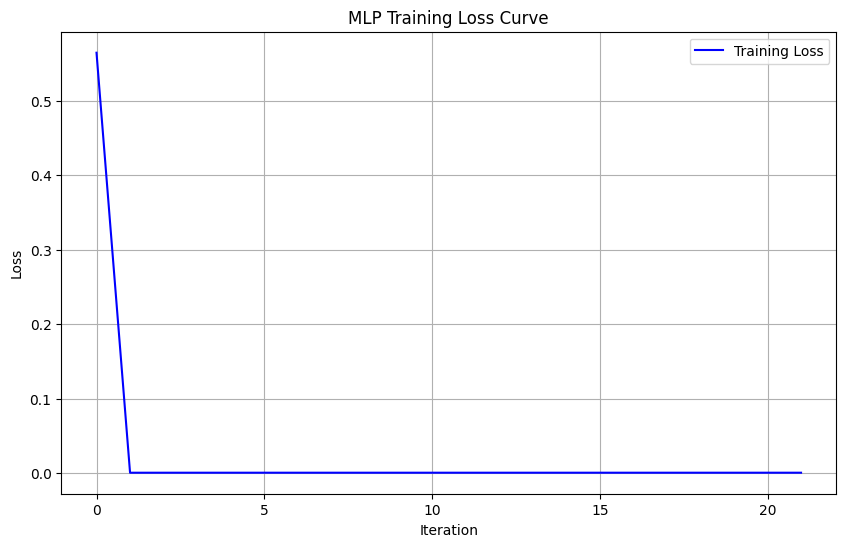

/tmp/ipykernel_10982/1937764261.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(1, len(cv_scores_mlp) + 1)), y=cv_scores_mlp, palette='viridis')


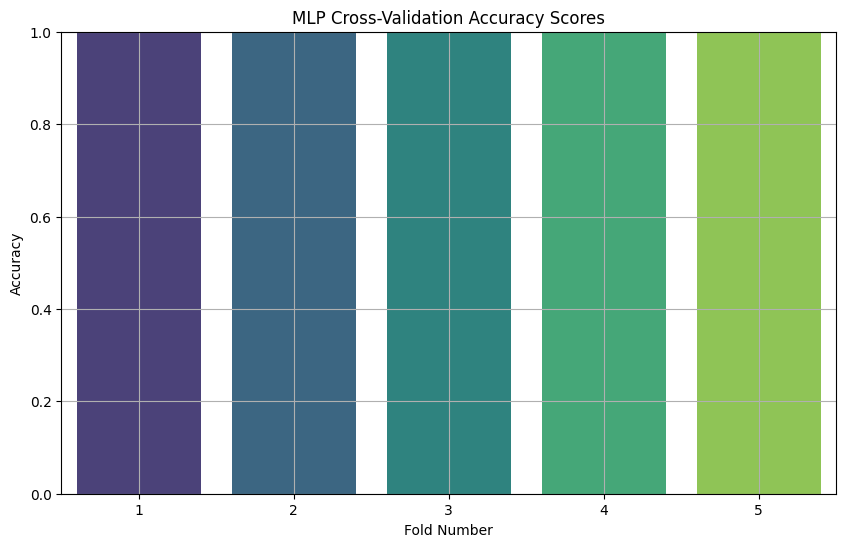

ValueError: Found input variables with inconsistent numbers of samples: [1140, 32]

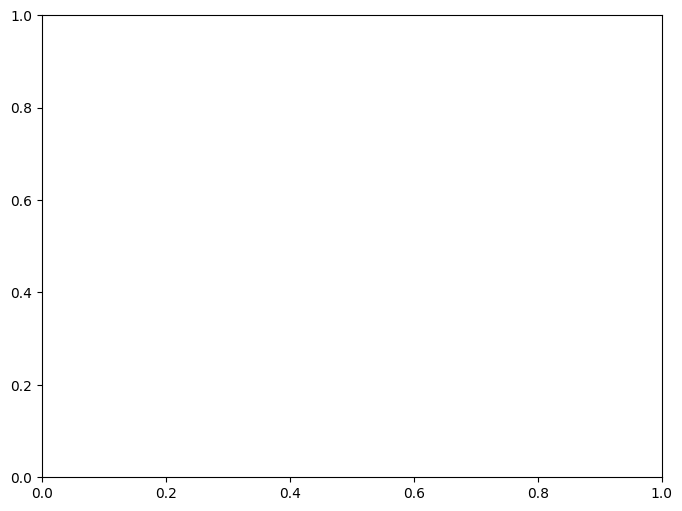

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting the training loss curve from the MLP model
if hasattr(mlp_model[-1], 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_model[-1].loss_curve_, label='Training Loss', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('MLP Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting cross-validation results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, len(cv_scores_mlp) + 1)), y=cv_scores_mlp, palette='viridis')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.title('MLP Cross-Validation Accuracy Scores')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# Plotting confusion matrix for MLP predictions
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, ax=ax, cmap='Blues')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

# ROC Curve for MLP Classifier
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(mlp_model, X_test, y_test, ax=ax)
plt.title('ROC Curve for MLP Classifier')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.inspection import permutation_importance
import numpy as np

# Permutation Importance to find most informative voxels
result = permutation_importance(mlp_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance = result.importances_mean

# Plotting voxel importance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(importance)), importance, marker='o', linestyle='-', color='purple')
plt.xlabel('Voxel Index')
plt.ylabel('Importance Score')
plt.title('Permutation Importance of Voxels for MLP Classification')
plt.grid(True)
plt.show()

KeyboardInterrupt: 